In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import zipfile
import shutil
%matplotlib inline
from scipy import ndimage, misc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchio as tio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import albumentations as alb
from albumentations.pytorch import ToTensor, ToTensorV2
import random
import cv2
import math
from patchify import patchify, unpatchify
import pickle
import skimage

/home/users/anastasb/.local/lib/python3.6/site-packages/scipy/__init__.py:147: UserWarning: NumPy 1.14.5 or above is required for this version of SciPy (detected version 1.14.3)
  UserWarning)


In [6]:
cd /scratch/users/anastasb

/scratch/users/anastasb


## Data and preprocessing

In [4]:
#Selected image names sorted by the adjusted EFC scores can be found at the bottom of the page.
#We select an equal amount of images (40) from each of the 5 sites, with the minimal scores in their respective group.
A_count = 0
B_count = 0
C_count = 0
D_count = 0
E_count = 0
select = []
for img in good_efc_sorted:
    l = img[-8]
    if l == "A" and A_count < 40:
        select.append(img)
        A_count += 1
    elif l == "B" and B_count < 40:
        select.append(img)
        B_count += 1
    elif l == "C" and C_count < 40:
        select.append(img)
        C_count += 1
    elif l == "D" and D_count < 40:
        select.append(img)
        D_count += 1
    elif l == "E" and E_count < 40:
        select.append(img)
        E_count += 1
    

In [9]:
import random

#select image names can be found at the bottom of the page
images = os.listdir('usable_t1_baseline/') #good images
images1 = [image for image in os.listdir('usable_t1_baseline/') if image in set(select)]

train_set, val_set = train_test_split(images1, test_size = 0.2,random_state=2018)
test_set = [image for image in os.listdir('usable_t1_baseline/') if image not in set(select)][:200]
test_set_unlabelled = os.listdir('motion_t1_artifacts_all/') #real bad images

In [10]:
def normalize(img): 
    #minmax normalization
    return (img- torch.min(img))/(torch.max(img)-torch.min(img))

In [11]:
SIZE = 128
DEPTH = 128
BASE_DIR = 'usable_t1_baseline/' #good images
ART_DIR1 = 'baseline_transformed1/' #transformed images with transform 1 (self-derived using torchio)
ART_DIR3 = 'baseline_transformed2/' #transformed images with transform 2 (self-derived using torchio)

class Data(Dataset): #modified compared to the base model
    """
    PyTorch Dataset generator class to be used in DataLoader
    inputs: list of filenames to each image;
    type:  train/validation dataset type;
    normalize: if True, normalize the images.
    """
    torch.manual_seed(2018)
    # Constructor
    def __init__(self, inputs: list,
                 normalize = True, data_type = 'train'):
        self.inputs = inputs  
        self.type = data_type
        self.normalize = normalize

    # Getter
    def __getitem__(self, index):
        """
        Returns base and transformed images, and their quality labels
        """
        torch.manual_seed(2018)
        X_img1 = nib.load(BASE_DIR+self.inputs[index])
        y1 = torch.tensor(0.0, dtype=torch.float)
        #parameter = -torch.rand(1) + 0.5 
        parameter = 0.5*torch.rand(1) #transform parameter
        transform = tio.Motion(degrees = [np.array((parameter,parameter,parameter))],
                        translation = [np.array((parameter,parameter,parameter))],
                       times = torch.arange(0,1,0.5)[1:].numpy(), image_interpolation='linear')

        image = tio.Image(BASE_DIR + self.inputs[index])    
        transformed_img = transform(image)
        
        X_array = X_img1.get_fdata() if len(X_img1.get_fdata().shape) < 4 else X_img1.get_fdata().squeeze(-1)
        X_array2 = transformed_img.data if len(transformed_img.data.shape) < 4 else transformed_img.data.squeeze(-1)

        if len(X_array.shape)>3:
            X_array = torch.tensor(X_array).squeeze(0)
        
        if len(X_array2.shape)>3:
            X_array2= torch.tensor(X_array2).squeeze(0)
            
        X_depth = X_img1.shape[2]
        pad = (X_depth-DEPTH)//2
        idx = range(pad,pad+DEPTH)
        X_array = resize(image = np.array(X_array[:,:,idx]))['image']
        X_array2 = resize(image = np.array(X_array2[:,:,idx]))['image']
        
        augment = torch.rand(2) #augment or not
        if self.type == 'train' and augment[0] > 0.5:
            X_array= hflip(image = X_array)['image']
            X_array2= hflip(image = X_array2)['image']
        if self.type == 'train' and augment[1] > 0.5:
            X_array = vflip(image = X_array)['image']
            X_array2 = vflip(image = X_array2)['image']
        
        X_array = torch.tensor(X_array)
        X_array2 = torch.tensor(X_array2)
        
        if self.normalize: #normalize during both training and testing 
            X_array = normalize(X_array)
            X_array2 = normalize(X_array2)
            
        y2 = torch.tensor(abs(parameter), dtype=torch.float)
        return (X_array.unsqueeze(0).float(),X_array2.unsqueeze(0).float()),(y1,y2)

    # Get length
    def __len__(self):
        return len(self.inputs)

In [12]:
#Synthetic Test Set
SIZE = 128
DEPTH = 128
BASE_DIR = 'usable_t1_baseline/'

class TestData(Dataset): 
    """
    Synthetic Test Dataset generator class.
    inputs: list of filenames to each image;
    normalize: if True, normalize
    """
    # Constructor
    def __init__(self, inputs: list,
                 normalize = True):
        self.inputs = inputs  # list of links to filenames
        self.normalize = normalize

    # Getter
    def __getitem__(self, index):
        """
        Returns the transformed image and its quality score
        """
        #torch.manual_seed(2018)
        parameter = torch.rand(1) #transform parameter, includes extrapolation
        transform = tio.Motion(degrees = [np.array((parameter,parameter,parameter))],
                        translation = [np.array((parameter,parameter,parameter))],
                       times = torch.arange(0,1,0.5)[1:].numpy(), image_interpolation='linear')
        image = tio.Image(BASE_DIR + self.inputs[index])    
        transformed_img = transform(image)
        
        X_array = transformed_img.data if len(transformed_img.data.shape) < 4 else transformed_img.data.squeeze(-1)


        if len(X_array.shape)>3:
            X_array = torch.tensor(X_array).squeeze(0)
            
        
        X_depth = X_array.shape[2]
        pad = (X_depth-DEPTH)//2
        idx = range(pad,pad+DEPTH)
        X_array = resize(image = np.array(X_array[:,:,idx]))['image']
    
        X_array = torch.tensor(X_array)
       
        if self.normalize: #normalize during both training and testing 
            X_array = normalize(X_array)
  
        y = torch.tensor(parameter, dtype=torch.float)
        return X_array.unsqueeze(0).float(), y

    # Get length
    def __len__(self):
        return len(self.inputs)

In [13]:
#Augmentations

resize = alb.Resize(width = SIZE, height = SIZE, p=1.0)
hflip = alb.HorizontalFlip(p=1)
vflip = alb.VerticalFlip(p=1)

augmentations = alb.Compose([
    alb.Resize(width = SIZE, height = SIZE, p=1.0),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomRotate90(p=0.5),
    alb.Transpose(p=0),
    ToTensor(),
])

augmentations_test = alb.Compose([
    alb.Resize(width = SIZE, height = SIZE, p=1.0),
    alb.HorizontalFlip(p=0),
    alb.VerticalFlip(p=0),
    alb.RandomRotate90(p=0),
    alb.Transpose(p=0),
    ToTensor(),
])


In [14]:
#Train
train_dataset = Data(inputs = train_set)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)

#Validation
val_dataset = Data(inputs = val_set,data_type = 'valid')
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=2, shuffle=True)

#Test
test_dataset = TestData(inputs = test_set)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=2, shuffle=False)

## Regression Ranking model

In [19]:
def double_conv(in_channels, out_channels):
    '''
    Helper function for the 3D Net architecture
    '''
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [16]:
device2 = torch.device('cuda:1') 
class Net(nn.Module):
    def __init__(self):
        #128x128x128
        super(Net, self).__init__()
        self.conv_down1 = double_conv(1, 32)
        self.conv_down2 = double_conv(32, 64)
        self.conv_down3 = double_conv(64, 128)
        self.conv_down4 = double_conv(128, 256)
        self.maxpool = nn.MaxPool3d((2,2,2))
        self.fc1 = nn.Linear(16*16*16*256, 1)

    def forward(self, x):
        inp = x
        x=x.half() 
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)        
        x = x.view(-1, 16*16*16*256)
        x = self.fc1(x)        
        return x


In [17]:
def _compute_val(model, loader, lambda_relative = 1.0):
    """
    Computes validation loss for the Motion Artifact Quantification Model
    :param model: model;
    :param loader: data loader;
    :param lambda_relative: ranking loss relative weight in the overall validation loss
    :return: validation loss
    """
    val_loss = 0
    with torch.no_grad():
        for i_step, (data, target) in enumerate(loader):
            data_base = data[0].to(device).half()
            data_bad = data[1].to(device).half()
            target_base = target[0].to(device)
            target_bad = target[1].to(device)
                    
            output_base, output_bad = model(data_base.half()), model(data_bad.half())
            target_base = target_base.type_as(output_base)
            target_bad = target_bad.type_as(output_bad)  
            
            criterion = nn.MSELoss()
            val_loss += criterion(output_base,target_base.unsqueeze(1))
            val_loss += criterion(output_bad,target_bad.unsqueeze(1))
            
            z = torch.tensor(0.0).cuda().half()
            val_loss += torch.mean(torch.where((output_base - output_bad)>0.0,
                                               (output_base - output_bad), z))*lambda_relative
            
            if torch.mean(output_base-output_bad)>0:
                val_loss += torch.mean(output_base-output_bad)*lambda_relative
               
    return (val_loss)/((i_step+1))

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=10):  
    
    loss_history = []
    val_losses = []

    
    for epoch in range(num_epochs):
        print("Epoch [%d] start" % (epoch))
        GPUtil.showUtilization()
        model.train()      
        losses = []
        lambda_relative = 1.0
        
        for i_step, (data, target) in enumerate(train_loader):
            print(str(i_step) + '...')
            data_base = data[0].half().to(device)
            data_bad = data[1].half().to(device)
            target_base = target[0].to(device)
            target_bad = target[1].to(device)                     
            output_base, output_bad = model(data_base),model(data_bad) 
            
            target_base = target_base.type_as(output_base)
            target_bad = target_bad.type_as(output_bad)
            loss = criterion(output_base,target_base.unsqueeze(1))
            loss += criterion(output_bad,target_bad.unsqueeze(1))

            z = torch.tensor(0.0).cuda().half()
            loss += torch.mean(torch.where((output_base - output_bad)>0.0,
                                           (output_base - output_bad), z))*lambda_relative #ranking loss
            
            if torch.mean(output_base-output_bad)>0: #additional batch level ranking loss
                loss += torch.mean(output_base-output_bad)*lambda_relative
                          
            losses.append(loss.item())
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_loss = _compute_val(model, val_loader)
        val_losses.append(val_loss)
        
        loss_history.append(np.array(losses).mean())
        
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "Mean loss on val:", val_loss,
              )
             
    return loss_history, val_losses

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
#device = torch.device("cuda:0")
p_net = model
p_net = p_net.half()

if torch.cuda.is_available():
    p_net.cuda()
    p_net = nn.DataParallel(model, device_ids = [0,1,2,3])

optimizer = torch.optim.Adam(p_net.parameters(), lr=1e-5, eps = 1e-4)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()

In [22]:
import GPUtil
#optimizer = torch.optim.Adam(p_net.parameters(), lr=1e-5, eps = 1e-4)
LOSS, val_losses = train_model(p_net,train_dataloader,val_dataloader,criterion,optimizer)

In [23]:
epoch = 30
torch.save({
           'epoch': epoch+1,
           'model_state_dict': p_net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
           'loss': train_loss_old + LOSS,
           
           'val loss': val_loss_old + val_losses,
         }, 'IQA_modified_weighted_no_rank0529.pth')

In [31]:
checkpoint = torch.load('IQA_modified_weighted_0520.pth') #Load the Regression model
#checkpoint = torch.load('IQA_modified_weighted_no_rank0529.pth')
p_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss_old = checkpoint['loss']
val_loss_old = checkpoint['val loss']

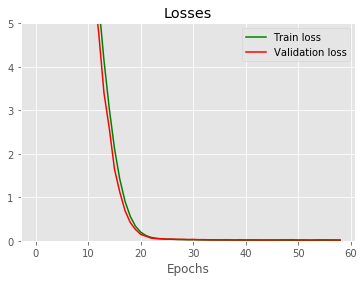

In [32]:
plt.style.use('ggplot')
plt.plot(train_loss_old, 'green', label='Train loss')
plt.plot(val_loss_old, 'red', label = 'Validation loss')
#plt.ylim((0, 0.005)) 
plt.ylim((0, 5)) 
plt.title('Losses')
plt.xlabel('Epochs')

plt.legend()

## Results

In [ ]:
#Calculate the Synthetic Test set predictions.
targets = []
outputs = []
with torch.no_grad():
    for (data, target) in test_dataloader:
        output = p_net(data.half())
        target = target.type_as(output)
        targets.append(target.item())
        outputs.append(output.item())
print('finished')

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: User

finished


In [34]:
#ranking loss
mse = np.mean((np.array(outputs)-np.array(targets))**2)
mae = np.sqrt(mse)
ybar = np.mean(np.array(targets))
r2 = 1 - np.sum((np.array(outputs)-np.array(targets))**2)/np.sum((np.array(targets)-ybar)**2)

print('mse:', mse)
print('mae:', mae)
print('R2:', r2)

mse: 0.023122684399295393
0.1520614494186327
0.5195776493543445


Text(0, 0.5, 'Targets')

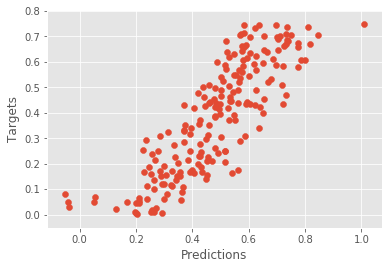

In [35]:
#Synthetic Test Set: Predictions-Targets
plt.scatter(outputs, targets)
plt.xlabel('Predictions')
plt.ylabel('Targets')

In [69]:
#Calculate Real Bad image scores (unlabelled)
scores = {}
for img in test_set:
    X_img = nib.load('motion_t1_artifacts_all/'+img)
    X_array = X_img.get_fdata() if len(X_img.get_fdata().shape) < 4 else X_img.get_fdata().squeeze(-1)
    if len(X_array.shape)>3:
        X_array = torch.tensor(X_array).squeeze(0)
    X_depth = X_img.shape[2]
    pad = (X_depth-DEPTH)//2
    idx = range(pad,pad+DEPTH)
    X_array = resize(image = np.array(X_array[:,:,idx]))['image']        
    X_array = torch.tensor(X_array)
    X_array = normalize(X_array)       
    with torch.no_grad():
        scores[img] = p_net(X_array.unsqueeze(0).unsqueeze(0).float())

In [70]:
scores_b_A = []
scores_b_B = []
scores_b_C = []
scores_b_D = []
scores_b_E = []

for key, value in scores.items():
    if key[0]=='A':
        scores_b_A.append(max(0,float(value)))
    elif key[0] == 'B':
        scores_b_B.append(max(0,float(value)))
    elif key[0] == 'C':
        scores_b_C.append(max(0,float(value)))
    elif key[0] == 'D':
        scores_b_D.append(max(0,float(value)))
    else:
        scores_b_E.append(max(0,float(value)))
        

In [ ]:
scores_g = {}
scores_3 = {} #image scores with trasnform parameter 2
for img in os.listdir('usable_t1_baseline/'):
    X_img = nib.load('usable_t1_baseline/'+img)
    X_img3 = nib.load(ART_DIR3+'transformed_'+img)
    X_array = X_img.get_fdata() if len(X_img.get_fdata().shape) < 4 else X_img.get_fdata().squeeze(-1)
    X_array3 = X_img3.get_fdata() if len(X_img3.get_fdata().shape) < 4 else X_img3.get_fdata().squeeze(-1)
    if len(X_array.shape)>3:
        X_array = torch.tensor(X_array).squeeze(0)
        X_array3 = torch.tensor(X_array3).squeeze(0)

    X_depth = X_img.shape[2]
    pad = (X_depth-DEPTH)//2
    idx = range(pad,pad+DEPTH)
    X_array = resize(image = np.array(X_array[:,:,idx]))['image']
    X_array3 = resize(image = np.array(X_array3[:,:,idx]))['image']
        
    X_array = torch.tensor(X_array)
    X_array = normalize(X_array)
    X_array3 = torch.tensor(X_array3)
    X_array3 = normalize(X_array3)
       
    with torch.no_grad():
        scores_g[img] = p_net(X_array.unsqueeze(0).unsqueeze(0).float())
        scores_3[img] = p_net(X_array3.unsqueeze(0).unsqueeze(0).float())
print('Finished')

Finished


In [74]:
scores_g_A = []
scores_g_B = []
scores_g_C = []
scores_g_D = []
scores_g_E = []

for key, value in scores_g.items():

    if key[-8]=='A':
        scores_g_A.append(max(0,float(value)))
    elif key[-8] == 'B':
        scores_g_B.append(max(0,float(value)))
    elif key[-8] == 'C':
        scores_g_C.append(max(0,float(value)))
    elif key[-8] == 'D':
        scores_g_D.append(max(0,float(value)))
    else:
        scores_g_E.append(max(0,float(value)))

In [60]:
scores_t_A = []
scores_t_B = []
scores_t_C = []
scores_t_D = []
scores_t_E = []

for key, value in scores_3.items():
    if key[-8]=='A':
        scores_t_A.append(float(value))
    elif key[-8] == 'B':
        scores_t_B.append(float(value))
    elif key[-8] == 'C':
        scores_t_C.append(float(value))
    elif key[-8] == 'D':
        scores_t_D.append(float(value))
    else:
        scores_t_E.append(float(value))

### Check the simulated images with larger transform - perfectly separable from the base ones

[Text(0, 0, 'g_A'),
 Text(0, 0, 't_A'),
 Text(0, 0, 'g_B'),
 Text(0, 0, 't_B'),
 Text(0, 0, 'g_C'),
 Text(0, 0, 't_C'),
 Text(0, 0, 'g_D'),
 Text(0, 0, 't_D'),
 Text(0, 0, 'g_E'),
 Text(0, 0, 't_E')]

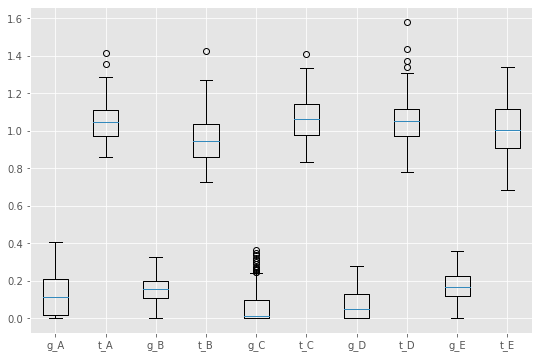

In [76]:
data_to_plot = [scores_g_A, scores_t_A,scores_g_B, scores_t_B, scores_g_C, scores_t_C,
                scores_g_D, scores_t_D, scores_g_E, scores_t_E]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['g_A','t_A','g_B', 't_B',
                    'g_C', 't_C','g_D',
                    't_D','g_E','t_E'], fontsize=10)

### Good and real bad image scores

[Text(0, 0, 'g_A'),
 Text(0, 0, 'b_A'),
 Text(0, 0, 'g_B'),
 Text(0, 0, 'b_B'),
 Text(0, 0, 'g_C'),
 Text(0, 0, 'b_C'),
 Text(0, 0, 'g_D'),
 Text(0, 0, 'b_D'),
 Text(0, 0, 'g_E'),
 Text(0, 0, 'b_E')]

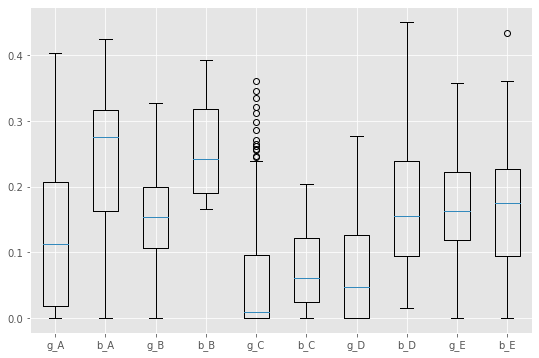

In [75]:
data_to_plot = [scores_g_A, scores_b_A,scores_g_B, scores_b_B, scores_g_C, scores_b_C,
                scores_g_D, scores_b_D, scores_g_E, scores_b_E]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['g_A','b_A','g_B', 'b_B',
                    'g_C', 'b_C','g_D',
                    'b_D','g_E','b_E'], fontsize=10)

## Image names sorted (ascending) by EFC adjusted

In [3]:
good_efc_sorted = ['NCANDA_S00141_E.nii.gz','NCANDA_S00052_E.nii.gz','NCANDA_S00831_E.nii.gz','NCANDA_S00249_E.nii.gz',
                   'NCANDA_S00485_E.nii.gz','NCANDA_S00910_E.nii.gz','NCANDA_S00446_E.nii.gz','NCANDA_S00294_E.nii.gz',
                   'NCANDA_S00218_E.nii.gz','NCANDA_S00708_A.nii.gz','NCANDA_S00135_E.nii.gz','NCANDA_S00598_B.nii.gz',
                   'NCANDA_S00043_E.nii.gz','NCANDA_S00985_E.nii.gz','NCANDA_S00537_E.nii.gz','NCANDA_S00115_E.nii.gz',
                   'NCANDA_S00408_E.nii.gz',
 'NCANDA_S00670_B.nii.gz',
 'NCANDA_S00914_E.nii.gz',
 'NCANDA_S00662_E.nii.gz',
 'NCANDA_S00769_E.nii.gz',
 'NCANDA_S00281_B.nii.gz',
 'NCANDA_S00315_E.nii.gz',
 'NCANDA_S00410_E.nii.gz',
 'NCANDA_S00261_E.nii.gz',
 'NCANDA_S00847_E.nii.gz',
 'NCANDA_S00369_E.nii.gz',
 'NCANDA_S00354_E.nii.gz',
 'NCANDA_S00606_B.nii.gz',
 'NCANDA_S00194_E.nii.gz',
 'NCANDA_S00642_E.nii.gz',
 'NCANDA_S00916_E.nii.gz',
 'NCANDA_S00250_E.nii.gz',
 'NCANDA_S00458_E.nii.gz',
 'NCANDA_S00222_E.nii.gz',
 'NCANDA_S00735_A.nii.gz',
 'NCANDA_S00740_B.nii.gz',
 'NCANDA_S00830_E.nii.gz',
 'NCANDA_S00059_E.nii.gz',
 'NCANDA_S00169_E.nii.gz',
 'NCANDA_S00961_E.nii.gz',
 'NCANDA_S00437_E.nii.gz',
 'NCANDA_S00790_A.nii.gz',
 'NCANDA_S00145_A.nii.gz',
 'NCANDA_S00845_E.nii.gz',
 'NCANDA_S00912_E.nii.gz',
 'NCANDA_S00232_B.nii.gz',
 'NCANDA_S00374_E.nii.gz',
 'NCANDA_S00819_E.nii.gz',
 'NCANDA_S00996_E.nii.gz',
 'NCANDA_S00207_E.nii.gz',
 'NCANDA_S00718_C.nii.gz',
 'NCANDA_S00108_E.nii.gz',
 'NCANDA_S00643_E.nii.gz',
 'NCANDA_S00237_B.nii.gz',
 'NCANDA_S00416_E.nii.gz',
 'NCANDA_S00933_E.nii.gz',
 'NCANDA_S00415_E.nii.gz',
 'NCANDA_S00876_B.nii.gz',
 'NCANDA_S00646_B.nii.gz',
 'NCANDA_S00219_E.nii.gz',
 'NCANDA_S00170_E.nii.gz',
 'NCANDA_S00097_E.nii.gz',
 'NCANDA_S00192_E.nii.gz',
 'NCANDA_S00676_B.nii.gz',
 'NCANDA_S00530_E.nii.gz',
 'NCANDA_S00217_E.nii.gz',
 'NCANDA_S00865_E.nii.gz',
 'NCANDA_S00034_E.nii.gz',
 'NCANDA_S00636_B.nii.gz',
 'NCANDA_S00140_E.nii.gz',
 'NCANDA_S00411_E.nii.gz',
 'NCANDA_S00801_B.nii.gz',
 'NCANDA_S00781_A.nii.gz',
 'NCANDA_S00116_E.nii.gz',
 'NCANDA_S00168_E.nii.gz',
 'NCANDA_S00420_B.nii.gz',
 'NCANDA_S00283_E.nii.gz',
 'NCANDA_S00107_E.nii.gz',
 'NCANDA_S00126_E.nii.gz',
 'NCANDA_S00389_E.nii.gz',
 'NCANDA_S00665_B.nii.gz',
 'NCANDA_S00652_E.nii.gz',
 'NCANDA_S00376_E.nii.gz',
 'NCANDA_S00451_E.nii.gz',
 'NCANDA_S00287_B.nii.gz',
 'NCANDA_S00247_E.nii.gz',
 'NCANDA_S00367_B.nii.gz',
 'NCANDA_S00421_E.nii.gz',
 'NCANDA_S01000_C.nii.gz',
 'NCANDA_S00828_E.nii.gz',
 'NCANDA_S00176_E.nii.gz',
 'NCANDA_S00051_E.nii.gz',
 'NCANDA_S00129_E.nii.gz',
 'NCANDA_S01003_B.nii.gz',
 'NCANDA_S00950_E.nii.gz',
 'NCANDA_S00938_E.nii.gz',
 'NCANDA_S00463_B.nii.gz',
 'NCANDA_S00216_E.nii.gz',
 'NCANDA_S00204_E.nii.gz',
 'NCANDA_S00033_E.nii.gz',
 'NCANDA_S00492_E.nii.gz',
 'NCANDA_S00422_E.nii.gz',
 'NCANDA_S00558_B.nii.gz',
 'NCANDA_S00939_E.nii.gz',
 'NCANDA_S00732_E.nii.gz',
 'NCANDA_S01009_C.nii.gz',
 'NCANDA_S00883_E.nii.gz',
 'NCANDA_S00072_E.nii.gz',
 'NCANDA_S00946_E.nii.gz',
 'NCANDA_S00619_B.nii.gz',
 'NCANDA_S00383_A.nii.gz',
 'NCANDA_S00857_A.nii.gz',
 'NCANDA_S00863_E.nii.gz',
 'NCANDA_S00975_B.nii.gz',
 'NCANDA_S00404_B.nii.gz',
 'NCANDA_S00504_B.nii.gz',
 'NCANDA_S00243_E.nii.gz',
 'NCANDA_S00853_D.nii.gz',
 'NCANDA_S00191_E.nii.gz',
 'NCANDA_S00770_B.nii.gz',
 'NCANDA_S00271_B.nii.gz',
 'NCANDA_S00265_E.nii.gz',
 'NCANDA_S00042_B.nii.gz',
 'NCANDA_S00915_E.nii.gz',
 'NCANDA_S00767_A.nii.gz',
 'NCANDA_S00306_B.nii.gz',
 'NCANDA_S00994_E.nii.gz',
 'NCANDA_S00061_A.nii.gz',
 'NCANDA_S00698_A.nii.gz',
 'NCANDA_S00651_E.nii.gz',
 'NCANDA_S00336_E.nii.gz',
 'NCANDA_S00862_E.nii.gz',
 'NCANDA_S00944_B.nii.gz',
 'NCANDA_S00396_C.nii.gz',
 'NCANDA_S00303_B.nii.gz',
 'NCANDA_S00142_E.nii.gz',
 'NCANDA_S00357_D.nii.gz',
 'NCANDA_S00657_C.nii.gz',
 'NCANDA_S00375_E.nii.gz',
 'NCANDA_S00649_B.nii.gz',
 'NCANDA_S00502_B.nii.gz',
 'NCANDA_S00091_C.nii.gz',
 'NCANDA_S00543_B.nii.gz',
 'NCANDA_S00335_E.nii.gz',
 'NCANDA_S00829_E.nii.gz',
 'NCANDA_S00264_B.nii.gz',
 'NCANDA_S00242_E.nii.gz',
 'NCANDA_S00241_E.nii.gz',
 'NCANDA_S00960_B.nii.gz',
 'NCANDA_S00572_D.nii.gz',
 'NCANDA_S00409_E.nii.gz',
 'NCANDA_S00307_A.nii.gz',
 'NCANDA_S00998_E.nii.gz',
 'NCANDA_S00371_B.nii.gz',
 'NCANDA_S00945_E.nii.gz',
 'NCANDA_S00943_E.nii.gz',
 'NCANDA_S00843_E.nii.gz',
 'NCANDA_S00299_B.nii.gz',
 'NCANDA_S00333_E.nii.gz',
 'NCANDA_S00257_C.nii.gz',
 'NCANDA_S00329_B.nii.gz',
 'NCANDA_S00925_E.nii.gz',
 'NCANDA_S00782_A.nii.gz',
 'NCANDA_S00715_C.nii.gz',
 'NCANDA_S00139_D.nii.gz',
 'NCANDA_S00539_B.nii.gz',
 'NCANDA_S00556_B.nii.gz',
 'NCANDA_S00742_B.nii.gz',
 'NCANDA_S00743_B.nii.gz',
 'NCANDA_S00952_E.nii.gz',
 'NCANDA_S00189_B.nii.gz',
 'NCANDA_S00541_B.nii.gz',
 'NCANDA_S00481_E.nii.gz',
 'NCANDA_S00325_B.nii.gz',
 'NCANDA_S00498_B.nii.gz',
 'NCANDA_S01001_B.nii.gz',
 'NCANDA_S00503_B.nii.gz',
 'NCANDA_S00466_D.nii.gz',
 'NCANDA_S00884_E.nii.gz',
 'NCANDA_S00248_C.nii.gz',
 'NCANDA_S00094_A.nii.gz',
 'NCANDA_S00062_E.nii.gz',
 'NCANDA_S00799_E.nii.gz',
 'NCANDA_S00882_E.nii.gz',
 'NCANDA_S00579_A.nii.gz',
 'NCANDA_S00482_E.nii.gz',
 'NCANDA_S00424_E.nii.gz',
 'NCANDA_S00917_B.nii.gz',
 'NCANDA_S00668_D.nii.gz',
 'NCANDA_S00109_A.nii.gz',
 'NCANDA_S00233_D.nii.gz',
 'NCANDA_S00879_A.nii.gz',
 'NCANDA_S00419_B.nii.gz',
 'NCANDA_S00427_B.nii.gz',
 'NCANDA_S00710_B.nii.gz',
 'NCANDA_S00814_B.nii.gz',
 'NCANDA_S00386_A.nii.gz',
 'NCANDA_S00759_C.nii.gz',
 'NCANDA_S00949_E.nii.gz',
 'NCANDA_S00983_B.nii.gz',
 'NCANDA_S00159_B.nii.gz',
 'NCANDA_S00332_E.nii.gz',
 'NCANDA_S00337_E.nii.gz',
 'NCANDA_S00479_B.nii.gz',
 'NCANDA_S00314_E.nii.gz',
 'NCANDA_S00870_B.nii.gz',
 'NCANDA_S00229_E.nii.gz',
 'NCANDA_S00640_C.nii.gz',
 'NCANDA_S00709_A.nii.gz',
 'NCANDA_S00905_B.nii.gz',
 'NCANDA_S00128_C.nii.gz',
 'NCANDA_S00304_E.nii.gz',
 'NCANDA_S00428_E.nii.gz',
 'NCANDA_S00350_B.nii.gz',
 'NCANDA_S00934_E.nii.gz',
 'NCANDA_S00245_D.nii.gz',
 'NCANDA_S00937_E.nii.gz',
 'NCANDA_S00555_B.nii.gz',
 'NCANDA_S00726_D.nii.gz',
 'NCANDA_S00858_A.nii.gz',
 'NCANDA_S00772_B.nii.gz',
 'NCANDA_S00647_B.nii.gz',
 'NCANDA_S00656_C.nii.gz',
 'NCANDA_S00755_C.nii.gz',
 'NCANDA_S00671_E.nii.gz',
 'NCANDA_S00600_A.nii.gz',
 'NCANDA_S00151_E.nii.gz',
 'NCANDA_S00661_C.nii.gz',
 'NCANDA_S00368_E.nii.gz',
 'NCANDA_S00848_E.nii.gz',
 'NCANDA_S00663_B.nii.gz',
 'NCANDA_S00505_A.nii.gz',
 'NCANDA_S00911_E.nii.gz',
 'NCANDA_S00185_B.nii.gz',
 'NCANDA_S00625_B.nii.gz',
 'NCANDA_S00992_B.nii.gz',
 'NCANDA_S00507_A.nii.gz',
 'NCANDA_S00867_E.nii.gz',
 'NCANDA_S00835_B.nii.gz',
 'NCANDA_S00385_A.nii.gz',
 'NCANDA_S00230_B.nii.gz',
 'NCANDA_S00347_D.nii.gz',
 'NCANDA_S00399_A.nii.gz',
 'NCANDA_S00251_C.nii.gz',
 'NCANDA_S00846_E.nii.gz',
 'NCANDA_S00617_A.nii.gz',
 'NCANDA_S00199_D.nii.gz',
 'NCANDA_S00531_E.nii.gz',
 'NCANDA_S00319_C.nii.gz',
 'NCANDA_S00605_B.nii.gz',
 'NCANDA_S00691_A.nii.gz',
 'NCANDA_S00067_C.nii.gz',
 'NCANDA_S00568_B.nii.gz',
 'NCANDA_S00403_D.nii.gz',
 'NCANDA_S00674_E.nii.gz',
 'NCANDA_S00724_C.nii.gz',
 'NCANDA_S00279_C.nii.gz',
 'NCANDA_S00631_E.nii.gz',
 'NCANDA_S00873_A.nii.gz',
 'NCANDA_S00491_A.nii.gz',
 'NCANDA_S00092_B.nii.gz',
 'NCANDA_S00163_B.nii.gz',
 'NCANDA_S00483_E.nii.gz',
 'NCANDA_S00627_A.nii.gz',
 'NCANDA_S00838_A.nii.gz',
 'NCANDA_S00785_E.nii.gz',
 'NCANDA_S00877_A.nii.gz',
 'NCANDA_S00981_E.nii.gz',
 'NCANDA_S00489_B.nii.gz',
 'NCANDA_S00826_A.nii.gz',
 'NCANDA_S00688_D.nii.gz',
 'NCANDA_S00175_B.nii.gz',
 'NCANDA_S00312_C.nii.gz',
 'NCANDA_S00353_E.nii.gz',
 'NCANDA_S00970_B.nii.gz',
 'NCANDA_S00956_B.nii.gz',
 'NCANDA_S00377_A.nii.gz',
 'NCANDA_S00471_E.nii.gz',
 'NCANDA_S00311_D.nii.gz',
 'NCANDA_S00224_A.nii.gz',
 'NCANDA_S01006_B.nii.gz',
 'NCANDA_S00406_A.nii.gz',
 'NCANDA_S00836_A.nii.gz',
 'NCANDA_S00372_B.nii.gz',
 'NCANDA_S00401_A.nii.gz',
 'NCANDA_S00167_E.nii.gz',
 'NCANDA_S00705_D.nii.gz',
 'NCANDA_S00776_A.nii.gz',
 'NCANDA_S00832_B.nii.gz',
 'NCANDA_S00205_E.nii.gz',
 'NCANDA_S00282_E.nii.gz',
 'NCANDA_S00658_C.nii.gz',
 'NCANDA_S00196_A.nii.gz',
 'NCANDA_S00796_C.nii.gz',
 'NCANDA_S01004_B.nii.gz',
 'NCANDA_S00164_B.nii.gz',
 'NCANDA_S00494_A.nii.gz',
 'NCANDA_S00988_B.nii.gz',
 'NCANDA_S00940_E.nii.gz',
 'NCANDA_S00840_D.nii.gz',
 'NCANDA_S00599_A.nii.gz',
 'NCANDA_S00957_B.nii.gz',
 'NCANDA_S00784_A.nii.gz',
 'NCANDA_S00114_A.nii.gz',
 'NCANDA_S00143_D.nii.gz',
 'NCANDA_S00345_B.nii.gz',
 'NCANDA_S00252_E.nii.gz',
 'NCANDA_S00210_D.nii.gz',
 'NCANDA_S00155_C.nii.gz',
 'NCANDA_S00632_D.nii.gz',
 'NCANDA_S00607_B.nii.gz',
 'NCANDA_S00256_D.nii.gz',
 'NCANDA_S00929_B.nii.gz',
 'NCANDA_S00805_A.nii.gz',
 'NCANDA_S00630_A.nii.gz',
 'NCANDA_S00081_C.nii.gz',
 'NCANDA_S00298_B.nii.gz',
 'NCANDA_S00302_B.nii.gz',
 'NCANDA_S00317_B.nii.gz',
 'NCANDA_S00382_A.nii.gz',
 'NCANDA_S00179_A.nii.gz',
 'NCANDA_S00473_A.nii.gz',
 'NCANDA_S00854_D.nii.gz',
 'NCANDA_S00119_E.nii.gz',
 'NCANDA_S00686_C.nii.gz',
 'NCANDA_S00423_E.nii.gz',
 'NCANDA_S00595_D.nii.gz',
 'NCANDA_S00165_C.nii.gz',
 'NCANDA_S00696_D.nii.gz',
 'NCANDA_S00260_B.nii.gz',
 'NCANDA_S00987_E.nii.gz',
 'NCANDA_S00855_B.nii.gz',
 'NCANDA_S00472_A.nii.gz',
 'NCANDA_S00825_A.nii.gz',
 'NCANDA_S00874_D.nii.gz',
 'NCANDA_S00557_B.nii.gz',
 'NCANDA_S00328_A.nii.gz',
 'NCANDA_S00516_D.nii.gz',
 'NCANDA_S00581_C.nii.gz',
 'NCANDA_S00654_A.nii.gz',
 'NCANDA_S00967_E.nii.gz',
 'NCANDA_S00997_E.nii.gz',
 'NCANDA_S00536_E.nii.gz',
 'NCANDA_S00963_E.nii.gz',
 'NCANDA_S00490_B.nii.gz',
 'NCANDA_S00648_A.nii.gz',
 'NCANDA_S00434_B.nii.gz',
 'NCANDA_S00737_D.nii.gz',
 'NCANDA_S00664_B.nii.gz',
 'NCANDA_S00618_A.nii.gz',
 'NCANDA_S00462_D.nii.gz',
 'NCANDA_S00677_B.nii.gz',
 'NCANDA_S00841_D.nii.gz',
 'NCANDA_S00569_B.nii.gz',
 'NCANDA_S00296_E.nii.gz',
 'NCANDA_S00391_D.nii.gz',
 'NCANDA_S00480_B.nii.gz',
 'NCANDA_S01002_B.nii.gz',
 'NCANDA_S00285_E.nii.gz',
 'NCANDA_S00999_B.nii.gz',
 'NCANDA_S00969_B.nii.gz',
 'NCANDA_S00364_C.nii.gz',
 'NCANDA_S00496_D.nii.gz',
 'NCANDA_S00962_E.nii.gz',
 'NCANDA_S00792_E.nii.gz',
 'NCANDA_S00084_C.nii.gz',
 'NCANDA_S00099_A.nii.gz',
 'NCANDA_S00808_E.nii.gz',
 'NCANDA_S00341_D.nii.gz',
 'NCANDA_S00976_B.nii.gz',
 'NCANDA_S00807_E.nii.gz',
 'NCANDA_S00549_C.nii.gz',
 'NCANDA_S00842_D.nii.gz',
 'NCANDA_S00442_E.nii.gz',
 'NCANDA_S00972_E.nii.gz',
 'NCANDA_S00093_A.nii.gz',
 'NCANDA_S00105_D.nii.gz',
 'NCANDA_S00612_D.nii.gz',
 'NCANDA_S00538_B.nii.gz',
 'NCANDA_S00244_B.nii.gz',
 'NCANDA_S00604_B.nii.gz',
 'NCANDA_S00722_B.nii.gz',
 'NCANDA_S00095_D.nii.gz',
 'NCANDA_S00190_D.nii.gz',
 'NCANDA_S00913_E.nii.gz',
 'NCANDA_S00951_B.nii.gz',
 'NCANDA_S00609_A.nii.gz',
 'NCANDA_S00809_C.nii.gz',
 'NCANDA_S00888_C.nii.gz',
 'NCANDA_S00680_A.nii.gz',
 'NCANDA_S00227_A.nii.gz',
 'NCANDA_S00773_E.nii.gz',
 'NCANDA_S00812_B.nii.gz',
 'NCANDA_S00338_E.nii.gz',
 'NCANDA_S00358_C.nii.gz',
 'NCANDA_S00501_B.nii.gz',
 'NCANDA_S00919_E.nii.gz',
 'NCANDA_S00460_D.nii.gz',
 'NCANDA_S00508_D.nii.gz',
 'NCANDA_S00611_D.nii.gz',
 'NCANDA_S00601_D.nii.gz',
 'NCANDA_S00456_E.nii.gz',
 'NCANDA_S00295_E.nii.gz',
 'NCANDA_S00239_E.nii.gz',
 'NCANDA_S00644_B.nii.gz',
 'NCANDA_S00635_C.nii.gz',
 'NCANDA_S00585_C.nii.gz',
 'NCANDA_S00733_A.nii.gz',
 'NCANDA_S00370_B.nii.gz',
 'NCANDA_S00849_D.nii.gz',
 'NCANDA_S00941_E.nii.gz',
 'NCANDA_S00355_E.nii.gz',
 'NCANDA_S00762_C.nii.gz',
 'NCANDA_S00653_B.nii.gz',
 'NCANDA_S00720_D.nii.gz',
 'NCANDA_S00318_D.nii.gz',
 'NCANDA_S00966_E.nii.gz',
 'NCANDA_S00390_E.nii.gz',
 'NCANDA_S00330_E.nii.gz',
 'NCANDA_S00771_A.nii.gz',
 'NCANDA_S00448_E.nii.gz',
 'NCANDA_S00868_E.nii.gz',
 'NCANDA_S00659_C.nii.gz',
 'NCANDA_S00429_E.nii.gz',
 'NCANDA_S00565_A.nii.gz',
 'NCANDA_S00413_C.nii.gz',
 'NCANDA_S00121_A.nii.gz',
 'NCANDA_S00433_B.nii.gz',
 'NCANDA_S00864_D.nii.gz',
 'NCANDA_S00553_C.nii.gz',
 'NCANDA_S00628_E.nii.gz',
 'NCANDA_S00666_D.nii.gz',
 'NCANDA_S00795_C.nii.gz',
 'NCANDA_S00684_B.nii.gz',
 'NCANDA_S00818_E.nii.gz',
 'NCANDA_S00365_B.nii.gz',
 'NCANDA_S00278_E.nii.gz',
 'NCANDA_S00584_C.nii.gz',
 'NCANDA_S00412_E.nii.gz',
 'NCANDA_S00387_D.nii.gz',
 'NCANDA_S00057_B.nii.gz',
 'NCANDA_S00699_A.nii.gz',
 'NCANDA_S00973_E.nii.gz',
 'NCANDA_S00320_A.nii.gz',
 'NCANDA_S00123_D.nii.gz',
 'NCANDA_S00234_A.nii.gz',
 'NCANDA_S00486_B.nii.gz',
 'NCANDA_S00173_C.nii.gz',
 'NCANDA_S00936_E.nii.gz',
 'NCANDA_S00310_A.nii.gz',
 'NCANDA_S00226_D.nii.gz',
 'NCANDA_S00289_D.nii.gz',
 'NCANDA_S00522_C.nii.gz',
 'NCANDA_S00866_D.nii.gz',
 'NCANDA_S00629_C.nii.gz',
 'NCANDA_S00932_B.nii.gz',
 'NCANDA_S00211_C.nii.gz',
 'NCANDA_S00393_D.nii.gz',
 'NCANDA_S00935_E.nii.gz',
 'NCANDA_S00624_B.nii.gz',
 'NCANDA_S00672_E.nii.gz',
 'NCANDA_S00361_C.nii.gz',
 'NCANDA_S00760_C.nii.gz',
 'NCANDA_S00174_D.nii.gz',
 'NCANDA_S00461_D.nii.gz',
 'NCANDA_S00747_C.nii.gz',
 'NCANDA_S00443_E.nii.gz',
 'NCANDA_S00923_C.nii.gz',
 'NCANDA_S00639_C.nii.gz',
 'NCANDA_S00291_D.nii.gz',
 'NCANDA_S00856_A.nii.gz',
 'NCANDA_S00273_B.nii.gz',
 'NCANDA_S00993_E.nii.gz',
 'NCANDA_S00090_C.nii.gz',
 'NCANDA_S00073_D.nii.gz',
 'NCANDA_S00407_E.nii.gz',
 'NCANDA_S00717_C.nii.gz',
 'NCANDA_S00366_D.nii.gz',
 'NCANDA_S00528_A.nii.gz',
 'NCANDA_S00112_D.nii.gz',
 'NCANDA_S00964_E.nii.gz',
 'NCANDA_S00266_B.nii.gz',
 'NCANDA_S00202_D.nii.gz',
 'NCANDA_S00804_A.nii.gz',
 'NCANDA_S00349_B.nii.gz',
 'NCANDA_S00534_D.nii.gz',
 'NCANDA_S00844_E.nii.gz',
 'NCANDA_S00512_E.nii.gz',
 'NCANDA_S00895_C.nii.gz',
 'NCANDA_S00445_C.nii.gz',
 'NCANDA_S00872_A.nii.gz',
 'NCANDA_S00465_D.nii.gz',
 'NCANDA_S00134_B.nii.gz',
 'NCANDA_S00655_C.nii.gz',
 'NCANDA_S00554_C.nii.gz',
 'NCANDA_S00974_B.nii.gz',
 'NCANDA_S00918_B.nii.gz',
 'NCANDA_S00276_E.nii.gz',
 'NCANDA_S00634_D.nii.gz',
 'NCANDA_S00817_E.nii.gz',
 'NCANDA_S00178_D.nii.gz',
 'NCANDA_S00183_B.nii.gz',
 'NCANDA_S00965_E.nii.gz',
 'NCANDA_S00694_D.nii.gz',
 'NCANDA_S00414_C.nii.gz',
 'NCANDA_S00258_A.nii.gz',
 'NCANDA_S00991_B.nii.gz',
 'NCANDA_S00800_A.nii.gz',
 'NCANDA_S00613_C.nii.gz',
 'NCANDA_S00893_C.nii.gz',
 'NCANDA_S00947_E.nii.gz',
 'NCANDA_S00637_C.nii.gz',
 'NCANDA_S00746_A.nii.gz',
 'NCANDA_S00638_C.nii.gz',
 'NCANDA_S00603_A.nii.gz',
 'NCANDA_S00136_A.nii.gz',
 'NCANDA_S00268_A.nii.gz',
 'NCANDA_S00980_B.nii.gz',
 'NCANDA_S00300_B.nii.gz',
 'NCANDA_S00834_D.nii.gz',
 'NCANDA_S00373_D.nii.gz',
 'NCANDA_S00457_E.nii.gz',
 'NCANDA_S00901_C.nii.gz',
 'NCANDA_S00813_B.nii.gz',
 'NCANDA_S00690_A.nii.gz',
 'NCANDA_S00464_C.nii.gz',
 'NCANDA_S00331_E.nii.gz',
 'NCANDA_S00253_E.nii.gz',
 'NCANDA_S00514_D.nii.gz',
 'NCANDA_S00060_E.nii.gz',
 'NCANDA_S00712_E.nii.gz',
 'NCANDA_S00346_B.nii.gz',
 'NCANDA_S00513_D.nii.gz',
 'NCANDA_S00922_C.nii.gz',
 'NCANDA_S00340_B.nii.gz',
 'NCANDA_S00871_A.nii.gz',
 'NCANDA_S00645_B.nii.gz',
 'NCANDA_S00590_A.nii.gz',
 'NCANDA_S00734_A.nii.gz',
 'NCANDA_S00495_A.nii.gz',
 'NCANDA_S00131_E.nii.gz',
 'NCANDA_S00327_D.nii.gz',
 'NCANDA_S00197_D.nii.gz',
 'NCANDA_S00891_C.nii.gz',
 'NCANDA_S00593_C.nii.gz',
 'NCANDA_S00622_B.nii.gz',
 'NCANDA_S00228_D.nii.gz',
 'NCANDA_S00284_E.nii.gz',
 'NCANDA_S00447_E.nii.gz',
 'NCANDA_S00904_B.nii.gz',
 'NCANDA_S00693_C.nii.gz',
 'NCANDA_S00518_C.nii.gz',
 'NCANDA_S00797_C.nii.gz',
 'NCANDA_S00894_C.nii.gz',
 'NCANDA_S00571_D.nii.gz',
 'NCANDA_S00206_E.nii.gz',
 'NCANDA_S00193_E.nii.gz',
 'NCANDA_S00452_D.nii.gz',
 'NCANDA_S00547_B.nii.gz',
 'NCANDA_S00689_D.nii.gz',
 'NCANDA_S00290_A.nii.gz',
 'NCANDA_S00395_D.nii.gz',
 'NCANDA_S00484_E.nii.gz',
 'NCANDA_S00587_B.nii.gz',
 'NCANDA_S00739_D.nii.gz',
 'NCANDA_S00810_C.nii.gz',
 'NCANDA_S00719_B.nii.gz',
 'NCANDA_S00583_C.nii.gz',
 'NCANDA_S00685_C.nii.gz',
 'NCANDA_S00161_D.nii.gz',
 'NCANDA_S00334_E.nii.gz',
 'NCANDA_S00545_D.nii.gz',
 'NCANDA_S00731_E.nii.gz',
 'NCANDA_S00449_D.nii.gz',
 'NCANDA_S00763_C.nii.gz',
 'NCANDA_S00561_C.nii.gz',
 'NCANDA_S00794_C.nii.gz',
 'NCANDA_S00322_C.nii.gz',
 'NCANDA_S00152_D.nii.gz',
 'NCANDA_S00820_C.nii.gz',
 'NCANDA_S00850_D.nii.gz',
 'NCANDA_S00444_C.nii.gz',
 'NCANDA_S00381_A.nii.gz',
 'NCANDA_S00552_C.nii.gz',
 'NCANDA_S00086_C.nii.gz',
 'NCANDA_S00096_E.nii.gz',
 'NCANDA_S00509_D.nii.gz',
 'NCANDA_S00280_C.nii.gz',
 'NCANDA_S00125_E.nii.gz',
 'NCANDA_S00259_D.nii.gz',
 'NCANDA_S00574_A.nii.gz',
 'NCANDA_S00450_D.nii.gz',
 'NCANDA_S00089_C.nii.gz',
 'NCANDA_S00425_D.nii.gz',
 'NCANDA_S00623_B.nii.gz',
 'NCANDA_S00827_C.nii.gz',
 'NCANDA_S00263_B.nii.gz',
 'NCANDA_S00184_D.nii.gz',
 'NCANDA_S00779_A.nii.gz',
 'NCANDA_S00426_B.nii.gz',
 'NCANDA_S00754_C.nii.gz',
 'NCANDA_S00924_C.nii.gz',
 'NCANDA_S00707_C.nii.gz',
 'NCANDA_S00417_D.nii.gz',
 'NCANDA_S00576_D.nii.gz',
 'NCANDA_S00467_C.nii.gz',
 'NCANDA_S00749_C.nii.gz',
 'NCANDA_S00524_C.nii.gz',
 'NCANDA_S00942_E.nii.gz',
 'NCANDA_S00352_D.nii.gz',
 'NCANDA_S00761_C.nii.gz',
 'NCANDA_S00570_A.nii.gz',
 'NCANDA_S00982_E.nii.gz',
 'NCANDA_S00379_A.nii.gz',
 'NCANDA_S00906_B.nii.gz',
 'NCANDA_S00309_B.nii.gz',
 'NCANDA_S00896_C.nii.gz',
 'NCANDA_S00272_A.nii.gz',
 'NCANDA_S00774_B.nii.gz',
 'NCANDA_S00673_E.nii.gz',
 'NCANDA_S00098_D.nii.gz',
 'NCANDA_S00563_D.nii.gz',
 'NCANDA_S00476_B.nii.gz',
 'NCANDA_S00344_C.nii.gz',
 'NCANDA_S00824_C.nii.gz',
 'NCANDA_S00620_A.nii.gz',
 'NCANDA_S00118_D.nii.gz',
 'NCANDA_S00499_C.nii.gz',
 'NCANDA_S00497_C.nii.gz',
 'NCANDA_S00745_A.nii.gz',
 'NCANDA_S01005_C.nii.gz',
 'NCANDA_S00269_B.nii.gz',
 'NCANDA_S00270_D.nii.gz',
 'NCANDA_S00815_D.nii.gz',
 'NCANDA_S00860_A.nii.gz',
 'NCANDA_S00729_A.nii.gz',
 'NCANDA_S00562_A.nii.gz',
 'NCANDA_S00083_C.nii.gz',
 'NCANDA_S00909_B.nii.gz',
 'NCANDA_S00156_C.nii.gz',
 'NCANDA_S00267_C.nii.gz',
 'NCANDA_S00288_D.nii.gz',
 'NCANDA_S00122_D.nii.gz',
 'NCANDA_S00959_E.nii.gz',
 'NCANDA_S00402_D.nii.gz',
 'NCANDA_S00697_A.nii.gz',
 'NCANDA_S00275_B.nii.gz',
 'NCANDA_S00566_A.nii.gz',
 'NCANDA_S00430_D.nii.gz',
 'NCANDA_S00892_C.nii.gz',
 'NCANDA_S00236_B.nii.gz',
 'NCANDA_S00816_E.nii.gz',
 'NCANDA_S00616_A.nii.gz',
 'NCANDA_S00076_A.nii.gz',
 'NCANDA_S00397_C.nii.gz',
 'NCANDA_S00154_D.nii.gz',
 'NCANDA_S00551_C.nii.gz',
 'NCANDA_S00487_D.nii.gz',
 'NCANDA_S00469_C.nii.gz',
 'NCANDA_S00293_B.nii.gz',
 'NCANDA_S00535_A.nii.gz',
 'NCANDA_S00902_C.nii.gz',
 'NCANDA_S00757_C.nii.gz',
 'NCANDA_S00540_B.nii.gz',
 'NCANDA_S00231_B.nii.gz',
 'NCANDA_S00478_B.nii.gz',
 'NCANDA_S00903_C.nii.gz',
 'NCANDA_S00209_C.nii.gz',
 'NCANDA_S00889_C.nii.gz',
 'NCANDA_S00316_C.nii.gz',
 'NCANDA_S00160_D.nii.gz',
 'NCANDA_S00626_D.nii.gz',
 'NCANDA_S00470_C.nii.gz',
 'NCANDA_S00388_E.nii.gz',
 'NCANDA_S00082_B.nii.gz',
 'NCANDA_S00953_E.nii.gz',
 'NCANDA_S00162_B.nii.gz',
 'NCANDA_S00532_D.nii.gz',
 'NCANDA_S00305_A.nii.gz',
 'NCANDA_S00195_B.nii.gz',
 'NCANDA_S00326_D.nii.gz',
 'NCANDA_S00246_D.nii.gz',
 'NCANDA_S00297_A.nii.gz',
 'NCANDA_S00633_D.nii.gz',
 'NCANDA_S00721_B.nii.gz',
 'NCANDA_S00575_D.nii.gz',
 'NCANDA_S00439_D.nii.gz',
 'NCANDA_S00529_A.nii.gz',
 'NCANDA_S00166_D.nii.gz',
 'NCANDA_S00187_B.nii.gz',
 'NCANDA_S00788_B.nii.gz',
 'NCANDA_S00775_B.nii.gz',
 'NCANDA_S00148_C.nii.gz',
 'NCANDA_S00564_D.nii.gz',
 'NCANDA_S00301_D.nii.gz',
 'NCANDA_S00703_D.nii.gz',
 'NCANDA_S00955_E.nii.gz',
 'NCANDA_S00519_C.nii.gz',
 'NCANDA_S00106_B.nii.gz',
 'NCANDA_S00220_D.nii.gz',
 'NCANDA_S00544_D.nii.gz',
 'NCANDA_S00577_D.nii.gz',
 'NCANDA_S00687_C.nii.gz',
 'NCANDA_S00435_C.nii.gz',
 'NCANDA_S00432_C.nii.gz',
 'NCANDA_S00608_A.nii.gz',
 'NCANDA_S00144_C.nii.gz',
 'NCANDA_S00225_D.nii.gz',
 'NCANDA_S00277_E.nii.gz',
 'NCANDA_S00833_D.nii.gz',
 'NCANDA_S00274_C.nii.gz',
 'NCANDA_S00453_A.nii.gz',
 'NCANDA_S00132_A.nii.gz',
 'NCANDA_S00897_C.nii.gz',
 'NCANDA_S00459_C.nii.gz',
 'NCANDA_S00602_A.nii.gz',
 'NCANDA_S00780_A.nii.gz',
 'NCANDA_S00798_C.nii.gz',
 'NCANDA_S00899_C.nii.gz',
 'NCANDA_S00488_B.nii.gz',
 'NCANDA_S00356_C.nii.gz',
 'NCANDA_S00723_C.nii.gz',
 'NCANDA_S00548_C.nii.gz',
 'NCANDA_S00321_D.nii.gz',
 'NCANDA_S00839_A.nii.gz',
 'NCANDA_S00675_D.nii.gz',
 'NCANDA_S00594_D.nii.gz',
 'NCANDA_S00077_A.nii.gz',
 'NCANDA_S00517_C.nii.gz',
 'NCANDA_S00822_A.nii.gz',
 'NCANDA_S00172_A.nii.gz',
 'NCANDA_S00560_C.nii.gz',
 'NCANDA_S00591_C.nii.gz',
 'NCANDA_S00586_B.nii.gz',
 'NCANDA_S00438_D.nii.gz',
 'NCANDA_S00474_D.nii.gz',
 'NCANDA_S00859_A.nii.gz',
 'NCANDA_S00678_D.nii.gz',
 'NCANDA_S00679_D.nii.gz',
 'NCANDA_S00454_A.nii.gz',
 'NCANDA_S00851_D.nii.gz',
 'NCANDA_S00262_D.nii.gz',
 'NCANDA_S00527_D.nii.gz',
 'NCANDA_S00235_D.nii.gz',
 'NCANDA_S00468_C.nii.gz',
 'NCANDA_S00885_C.nii.gz',
 'NCANDA_S00741_A.nii.gz',
 'NCANDA_S00783_A.nii.gz',
 'NCANDA_S00758_C.nii.gz',
 'NCANDA_S00752_C.nii.gz',
 'NCANDA_S00615_C.nii.gz',
 'NCANDA_S00898_C.nii.gz',
 'NCANDA_S00215_B.nii.gz',
 'NCANDA_S00546_C.nii.gz',
 'NCANDA_S00890_C.nii.gz',
 'NCANDA_S00342_C.nii.gz',
 'NCANDA_S00526_D.nii.gz',
 'NCANDA_S00753_C.nii.gz',
 'NCANDA_S00363_C.nii.gz',
 'NCANDA_S00778_A.nii.gz',
 'NCANDA_S00958_C.nii.gz',
 'NCANDA_S00323_C.nii.gz',
 'NCANDA_S00455_C.nii.gz',
 'NCANDA_S00436_C.nii.gz',
 'NCANDA_S00238_D.nii.gz',
 'NCANDA_S00343_B.nii.gz',
 'NCANDA_S00506_A.nii.gz',
 'NCANDA_S00852_D.nii.gz',
 'NCANDA_S00614_D.nii.gz',
 'NCANDA_S00704_D.nii.gz',
 'NCANDA_S00213_A.nii.gz',
 'NCANDA_S00254_D.nii.gz',
 'NCANDA_S00378_A.nii.gz',
 'NCANDA_S00592_A.nii.gz',
 'NCANDA_S00713_D.nii.gz',
 'NCANDA_S00130_D.nii.gz',
 'NCANDA_S00756_C.nii.gz',
 'NCANDA_S00150_D.nii.gz',
 'NCANDA_S00362_C.nii.gz',
 'NCANDA_S00578_D.nii.gz',
 'NCANDA_S00292_D.nii.gz',
 'NCANDA_S00078_B.nii.gz',
 'NCANDA_S00520_C.nii.gz',
 'NCANDA_S00559_C.nii.gz',
 'NCANDA_S00900_C.nii.gz',
 'NCANDA_S00500_C.nii.gz',
 'NCANDA_S00214_D.nii.gz',
 'NCANDA_S00550_C.nii.gz',
 'NCANDA_S00351_D.nii.gz',
 'NCANDA_S00887_C.nii.gz',
 'NCANDA_S00714_C.nii.gz',
 'NCANDA_S00597_C.nii.gz',
 'NCANDA_S00515_D.nii.gz',
 'NCANDA_S00802_A.nii.gz',
 'NCANDA_S00660_C.nii.gz',
 'NCANDA_S00764_C.nii.gz',
 'NCANDA_S00875_D.nii.gz',
 'NCANDA_S00748_C.nii.gz',
 'NCANDA_S00510_C.nii.gz',
 'NCANDA_S00182_D.nii.gz',
 'NCANDA_S00308_D.nii.gz',
 'NCANDA_S00886_C.nii.gz',
 'NCANDA_S00730_A.nii.gz',
 'NCANDA_S00725_C.nii.gz',
 'NCANDA_S00793_C.nii.gz',
 'NCANDA_S00702_A.nii.gz',
 'NCANDA_S00255_D.nii.gz',
 'NCANDA_S00431_C.nii.gz',
 'NCANDA_S00669_D.nii.gz',
 'NCANDA_S00573_D.nii.gz',
 'NCANDA_S00811_C.nii.gz',
 'NCANDA_S00117_D.nii.gz',
 'NCANDA_S00990_C.nii.gz',
 'NCANDA_S00511_C.nii.gz',
 'NCANDA_S00751_C.nii.gz',
 'NCANDA_S00582_C.nii.gz',
 'NCANDA_S01010_C.nii.gz',
 'NCANDA_S00580_C.nii.gz',
 'NCANDA_S00153_A.nii.gz',
 'NCANDA_S00641_C.nii.gz',
 'NCANDA_S00394_C.nii.gz',
 'NCANDA_S00339_C.nii.gz',
 'NCANDA_S00104_B.nii.gz',
 'NCANDA_S00398_C.nii.gz',
 'NCANDA_S00360_C.nii.gz',
 'NCANDA_S00525_D.nii.gz',
 'NCANDA_S00750_C.nii.gz',
 'NCANDA_S00728_C.nii.gz',
 'NCANDA_S00695_D.nii.gz',
 'NCANDA_S00475_A.nii.gz']